### import libraries

In [1]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.graphics.api import abline_plot
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
import itertools
from itertools import product
from scipy.stats import gaussian_kde,chi2_contingency,gamma, ttest_rel
from numpy.linalg import LinAlgError

### load the dataset

In [13]:
FILEPATH = 'dispersion_and_reaction_data.xlsx'#please change the folder path to the location the data was saved

df = pd.read_excel(FILEPATH)

df

,Intercept,Fatigue,Distractor,Occlusion,TwoBack,RT,Yaw_Rad,Pitch_Rad,Yaw_Degree,Pitch_Degree,Reacted_Before_TOR,Crash,Occlusion_Yaw_Rad,Occlusion_Ptich_Rad,Occlusion_Yaw_Degree,Occlusion_Ptich_Degree
0,1,1,1,1,0,1.57,0.22,0.18,12.605071,10.313240,0,0,0.051889,0.096396,2.973029,5.523089
1,1,1,1,1,0,1.52,0.22,0.20,12.605071,11.459156,0,0,0.155426,0.155898,8.905232,8.932301
2,1,1,1,1,0,1.02,0.21,0.18,12.032114,10.313240,1,0,0.070640,0.032166,4.047363,1.842988
3,1,1,1,1,0,2.00,0.16,0.19,9.167325,10.886198,0,0,0.135802,0.134935,7.780893,7.731212
4,1,1,1,1,0,1.25,0.21,0.19,12.032114,10.886198,1,0,0.142704,0.076600,8.176328,4.388863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,1,0,3,1,1,1.32,0.15,0.22,8.594367,12.605071,0,0,0.095600,0.175687,5.477461,10.066134
101,1,0,3,1,1,1.60,0.18,0.18,10.313240,10.313240,0,0,0.121104,0.036539,6.938770,2.093529
102,1,1,3,1,1,2.23,0.21,0.21,12.032114,12.032114,0,1,0.160055,0.162122,9.170455,9.288905
103,1,1,3,1,1,1.83,0.11,0.18,6.302536,10.313240,0,1,0.198468,0.182950,11.371351,10.482274


## model functions

In [3]:
def getCondName(c1, c2):
    '''
    Receives the condition values for occlusion and two back
    and returns the name to be placed in the plot
    '''
    if (c1 == 1 and c2 == 0):
        condName = 'Occlusion'
    elif (c1 == 0 and c2 == 1):
        condName = '2-Back'
    else:
        condName = 'Occlusion + 2-Back'
        
    return condName

In [4]:
def run_gamma_with_emm_filtered_no_fatigue(df, DV, n_sims=2000):
    """
    Fit Gamma GLM (log link) and compute EMMs for the three key combinations:
    (Occlusion, TwoBack) = (0,1), (1,0), (1,1)
    Fatigue is included in the model but removed from the EMM table.
    """
    # Fit the model
    formula = f"{DV} ~ Occlusion:Fatigue + TwoBack:Fatigue + Occlusion + TwoBack"
    glm_model = smf.glm(formula=formula,
                        data=df,
                        family=sm.families.Gamma(link=sm.families.links.log()))
    res = glm_model.fit()

    # Levels of Fatigue
    fatigue_levels = sorted(df["Fatigue"].dropna().unique())

    # Only keep these 3 combinations
    combos_to_keep = [(0,1), (1,0), (1,1)]

    emms_list = []

    for o, t in combos_to_keep:
        # Collect simulations across fatigue levels
        all_sims = []
        for f in fatigue_levels:
            row = {"Occlusion": o, "TwoBack": t, "Fatigue": f}
            # Set other columns to mean if any
            for col in df.columns:
                if col not in ["Occlusion", "TwoBack", "Fatigue", DV]:
                    row[col] = df[col].mean()
            pred_df = pd.DataFrame([row])

            # Simulate predictions
            mu = res.predict(pred_df)[0]
            phi = res.scale
            shape = 1 / phi
            scale = mu * phi
            sims = gamma.rvs(a=shape, scale=scale, size=n_sims)
            all_sims.append(sims)

        # Flatten all sims across fatigue
        all_sims = np.concatenate(all_sims)

        emms_list.append({
            "Occlusion": o,
            "TwoBack": t,
            "Predicted_Mean": np.mean(all_sims),
            "SD": np.std(all_sims),
            "CI_2.5": np.percentile(all_sims, 2.5),
            "CI_97.5": np.percentile(all_sims, 97.5)
        })

    emms_df = pd.DataFrame(emms_list)

    return res, emms_df


In [5]:
def simulate_gamma_predictions(model_res, df_subset, n_sims=2000):
    """
    Simulate a distribution of predicted values from a Gamma GLM with log link.
    Handles both single-row and multi-row dataframes.
    """
    mu = model_res.predict(df_subset)
    if np.isscalar(mu):
        mu = np.array([mu])
    else:
        mu = np.array(mu)

    phi = model_res.scale

    shape = 1 / phi
    scale = mu * phi

    if np.isscalar(shape):
        shape = np.full_like(mu, shape, dtype=float)
    if np.isscalar(scale):
        scale = np.full_like(mu, scale, dtype=float)

    sims = [gamma.rvs(a=shape[i], scale=scale[i], size=n_sims) for i in range(len(mu))]
    sims_flat = np.concatenate(sims)
    return sims_flat

In [6]:
def posthoc_emms_ttests(model_res, df, DV, n_sims=2000):
    """
    Run paired-sample t-tests between 3 hardcoded EMM conditions:
    (Occlusion, TwoBack) = (0,1), (1,0), (1,1)
    
    Parameters
    ----------
    model_res : fitted statsmodels GLM results
    df : original dataframe (for column info)
    DV : dependent variable name (string)
    n_sims : number of simulated draws per condition
    """
    combos_to_keep = [(0,1), (1,0), (1,1)]
    sims_dict = {}

    # Generate simulations for each condition
    for o, t in combos_to_keep:
        row = {"Occlusion": o, "TwoBack": t}
        # Fill other columns with mean
        for col in df.columns:
            if col not in ["Occlusion", "TwoBack", DV, "Fatigue"]:
                row[col] = df[col].mean()
        # Keep Fatigue fixed at 0 (or mean if numeric)
        if "Fatigue" in df.columns:
            row["Fatigue"] = 0
        pred_df = pd.DataFrame([row])

        mu = model_res.predict(pred_df)[0]
        phi = model_res.scale
        shape = 1 / phi
        scale = mu * phi
        sims = gamma.rvs(a=shape, scale=scale, size=n_sims)
        sims_dict[(o,t)] = sims

    # Run paired t-tests
    pairs = list(itertools.combinations(combos_to_keep, 2))
    results_list = []
    for c1, c2 in pairs:
        sims1 = sims_dict[c1]
        sims2 = sims_dict[c2]
        t_stat, p_val = ttest_rel(sims1, sims2)
        results_list.append({
            "Comparison": f"{c1} vs {c2}",
            "t_stat": t_stat,
            "p_value": p_val
        })

    return pd.DataFrame(results_list)


In [7]:
def plot_three_condition_kdes(df, DV, model_res, cond1, cond2,
                              combos=None, n_sims=2000,
                              match_y_scale=True):
    """
    Plot KDE curves of the predicted Gamma distributions for three
    specified condition combinations, all on one shared plot.
    """

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    from numpy.linalg import LinAlgError

    if combos is None:
        combos = [(0, 1), (1, 0), (1, 1)]

    plt.figure(figsize=(10, 6))

    kde_curves = []
    x_ranges = []

    # ----- SIMULATE + COMPUTE KDE FOR EACH CONDITION -----
    for c1, c2 in combos:
        subset = df[(df[cond1] == c1) & (df[cond2] == c2)]

        if subset.empty:
            print(f"Warning: No data for {cond1}={c1}, {cond2}={c2}. Skipping.")
            continue

        predicted = simulate_gamma_predictions(model_res, subset, n_sims=n_sims)

        # KDE x-range for this condition
        x_vals = np.linspace(predicted.min(), predicted.max(), 300)

        # Compute KDE
        try:
            if np.std(predicted) < 1e-12:
                kde_vals = np.zeros_like(x_vals)
                idx = np.argmin(np.abs(x_vals - predicted.mean()))
                kde_vals[idx] = 1  # spike
            else:
                kde = gaussian_kde(predicted)
                kde_vals = kde(x_vals)

        except LinAlgError:
            kde_vals = np.zeros_like(x_vals)
            idx = np.argmin(np.abs(x_vals - predicted.mean()))
            kde_vals[idx] = 1

        kde_curves.append({
            "label": getCondName(c1, c2),#f"{cond1}={c1}, {cond2}={c2}",
            "x": x_vals,
            "kde": kde_vals
        })
        x_ranges.append((x_vals.min(), x_vals.max()))

    # ----- Compute global x-limits -----
    if x_ranges:
        xmin_global = min(r[0] for r in x_ranges)
        xmax_global = max(r[1] for r in x_ranges)

    # ----- Optional: match all curves to same max height -----
    if match_y_scale:
        global_max = max(curve["kde"].max() for curve in kde_curves)
        for curve in kde_curves:
            curve["kde"] = curve["kde"] / curve["kde"].max() * global_max

    # ----- PLOT -----
    for curve in kde_curves:
        plt.plot(curve["x"], curve["kde"], lw=2, label=curve["label"])
    # ---- Vertical Lines ----
    plt.axvline(x = 1.27, label = 'TOR', color = 'black', linestyle = '--', linewidth = 2)#1.127 is the time it took between the lead brake lights onset and the TOR
    plt.axvline(x = 3.0, label = 'Crash', color = 'red', linestyle = '--', linewidth = 2)


    plt.xlim(xmin_global, xmax_global)
    plt.xlabel(DV)
    plt.ylabel("Density", fontsize = 18)
    plt.xlabel("Time (s)", fontsize = 18)
    plt.ylim (0, 1.199)
    plt.legend(fontsize = 16, facecolor='white', framealpha=1, bbox_to_anchor=(1, 0.6))
    plt.tight_layout()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [8]:
def probability_above_threshold_with_chi2(
        df, DV, model_res, cond1, cond2, TOR,
        combos=None, n_sims=2000, verbose=True):
    '''
    Run model predictions of for the probability of drivers to respond before a given threshold
    TOR = 1.27 -> probability of responding before TOR
    TOR = 3.0 -> probability of responding before crashing
    '''
    if combos is None:
        combos = [(0,1), (1,0), (1,1)]

    results = []
    sims_dict = {}  # store simulated arrays for pairwise tests

    # ------------------------------
    # 1. Compute probabilities
    # ------------------------------
    for c1, c2 in combos:
        subset = df[(df[cond1] == c1) & (df[cond2] == c2)]

        label = f"{cond1}={c1}, {cond2}={c2}"

        if subset.empty:
            results.append({
                "Condition": label,
                "Probability_above_TOR": np.nan,
                "N": 0
            })
            continue

        # Simulate Gamma predictions
        sims = simulate_gamma_predictions(model_res, subset, n_sims=n_sims)
        sims_dict[label] = sims

        prob = np.mean(sims > TOR)

        results.append({
            "Condition": label,
            "Probability_above_TOR": prob,
            "N": len(sims)
        })

    results_df = pd.DataFrame(results)

    # ------------------------------
    # 2. Pairwise chi-squared tests
    # ------------------------------
    chi2_rows = []

    labels = list(sims_dict.keys())
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):

            labelA = labels[i]
            labelB = labels[j]

            simsA = sims_dict[labelA]
            simsB = sims_dict[labelB]

            # Build 2×2 contingency table
            A_above = np.sum(simsA > TOR)
            A_below = np.sum(simsA <= TOR)

            B_above = np.sum(simsB > TOR)
            B_below = np.sum(simsB <= TOR)

            table = np.array([
                [A_above, A_below],
                [B_above, B_below]
            ])

            chi2, p, dof, expected = chi2_contingency(table)

            # Who is higher?
            better = labelA if (A_above / len(simsA)) > (B_above / len(simsB)) else labelB

            chi2_rows.append({
                "Comparison": f"{labelA} vs {labelB}",
                "Chi2": chi2,
                "p_value": p,
                "Higher_Prob_Condition": better
            })

    chi2_df = pd.DataFrame(chi2_rows)

    # ------------------------------
    # PRINT RESULTS
    # ------------------------------
    if verbose:
        print("\n===== Probability Predicted Value > TOR =====\n")
        print(results_df.to_string(index=False))

        print("\n===== Pairwise Chi-Squared Tests =====\n")
        print(chi2_df.to_string(index=False))

    return results_df, chi2_df


In [9]:
def plot_predictions_three_conditions_single_legend(df, DV, model_res, cond1, cond2, xLabel, combos=None, n_sims=2000):
    """
    Plots histograms of observed data with overlaid KDE of predicted Gamma distributions
    for specified combinations of two conditions, with a single legend outside the right.
    """
    if combos is None:
        combos = [(0, 1), (1, 0), (1, 1)]
    
    fig, axes = plt.subplots(1, len(combos), figsize=(6 * len(combos), 5))
    if len(combos) == 1:
        axes = [axes]

    # First pass: determine global X and Y limits
    xmins, xmaxs, ymaxs = [], [], []
    subset_dict = {}

    for c1, c2 in combos:
        subset = df[(df[cond1] == c1) & (df[cond2] == c2)]
        subset_dict[(c1, c2)] = subset
        if subset.empty:
            continue
        real_data = subset[DV].dropna()
        predicted = simulate_gamma_predictions(model_res, subset, n_sims=n_sims)
        xmins.append(min(real_data.min(), predicted.min()))
        xmaxs.append(max(real_data.max(), predicted.max()))
        counts, _ = np.histogram(real_data, bins=20)
        kde_vals = gaussian_kde(predicted)(np.linspace(predicted.min(), predicted.max(), 300))
        ymaxs.append(max(max(counts), max(kde_vals)))

    xmin_global = min(xmins) if xmins else None
    xmax_global = max(xmaxs) if xmaxs else None
    ymax_global = max(ymaxs) * 1.05 if ymaxs else None

    # Plotting
    for ax, (c1, c2) in zip(axes, combos):
        subset = subset_dict[(c1, c2)]
        if subset.empty:
            ax.set_title(f"{cond1}={c1}, {cond2}={c2}\n(no data)")
            ax.axis("off")
            continue

        real_data = subset[DV].dropna()
        predicted = simulate_gamma_predictions(model_res, subset, n_sims=n_sims)

        x_vals = np.linspace(predicted.min(), predicted.max(), 300)

        # HISTOGRAM
        counts, bins, _ = ax.hist(real_data, bins=20, color="blue", alpha=0.4,
                                  edgecolor='black', linewidth=1.0, rwidth=0.9,
                                  label="Experimental Data")
        hist_height = max(counts) if max(counts) > 0 else 1

        # KDE
        try:
            if np.std(predicted) < 1e-12:
                ax.axvline(predicted.mean(), color="black", lw=2, linestyle='dotted', label="Predicted Mean")
            else:
                kde = gaussian_kde(predicted)
                kde_vals = kde(x_vals)
                kde_scaled = kde_vals * (hist_height * 0.8) / np.max(kde_vals)
                ax.plot(x_vals, kde_scaled, color="black", lw=2, label="Empirical PDF")
                mean_pred = predicted.mean()
                idx_closest = np.argmin(np.abs(x_vals - mean_pred))
                ymax = kde_scaled[idx_closest]
                ax.vlines(mean_pred, ymin=0, ymax=ymax, color='black', linestyle='dotted', lw=2, label='Predicted Mean')
        except:
            ax.axvline(predicted.mean(), color="black", lw=2, linestyle='dotted', label="Predicted Mean")

#         ax.set_title(f"{cond1}={c1}, {cond2}={c2}", fontsize = 16) 
        ax.set_title (getCondName (c1,c2),fontsize = 16)
        if xmin_global is not None:
            ax.set_xlim(xmin_global, xmax_global)
        if ymax_global is not None:
            ax.set_ylim(0, ymax_global)
        ax.set_xlabel(xLabel, fontsize=16)
        ax.set_ylabel("Frequency", fontsize=16)
        ax.tick_params(axis='both', labelsize=14)
        # REMOVE ax.legend() here

    # --- SINGLE LEGEND OUTSIDE ---
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l

    # Remove duplicate labels
    from collections import OrderedDict
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center left', 
               bbox_to_anchor=(0.75, 0.5), fontsize=16, facecolor='white', framealpha=1, edgecolor='black')

    plt.tight_layout()
    plt.subplots_adjust(right=0.75)  # leave space for legend
    plt.show()

In [10]:
def chi2_2x2_manual(a, b, c, d):
    """
    Manual Pearson chi-square for 2x2 table:
    a b
    c d
    Returns chi2 statistic.
    """
    n = a + b + c + d
    chi2 = n * (a*d - b*c)**2 / ((a+b)*(c+d)*(a+c)*(b+d))
    return chi2

def run_all_chi_tests_fixed_manual(df, target_var, cond1="Occlusion", cond2="TwoBack"):
    """
    Runs independent chi-square tests for 3 comparisons:
      1) Occlusion1_2Back0 vs Occlusion0_2Back1
      2) Occlusion1_2Back0 vs Occlusion1_2Back1
      3) Occlusion0_2Back1 vs Occlusion1_2Back1

    Uses manual 2x2 chi-square formula for exact match with hand calculations.

    Returns a DataFrame with counts, chi2, p-value (approx from chi2 1 df), and table.
    """
    from scipy.stats import chi2 as chi2_dist

    # Define comparisons
    comparisons = [
        {"A": (1,0), "B": (0,1), "name": "Occlusion1_2Back0 vs Occlusion0_2Back1"},
        {"A": (1,0), "B": (1,1), "name": "Occlusion1_2Back0 vs Occlusion1_2Back1"},
        {"A": (0,1), "B": (1,1), "name": "Occlusion0_2Back1 vs Occlusion1_2Back1"}
    ]

    results = []

    for comp in comparisons:
        # Subset groups
        dfA = df[(df[cond1]==comp["A"][0]) & (df[cond2]==comp["A"][1])]
        dfB = df[(df[cond1]==comp["B"][0]) & (df[cond2]==comp["B"][1])]

        A_pos = (dfA[target_var]==1).sum()
        A_neg = (dfA[target_var]==0).sum()
        B_pos = (dfB[target_var]==1).sum()
        B_neg = (dfB[target_var]==0).sum()

        # Build 2x2 table
        table = np.array([
            [A_pos, A_neg],
            [B_pos, B_neg]
        ])

        # Manual chi-square
        chi2 = chi2_2x2_manual(A_pos, A_neg, B_pos, B_neg)

        # Approximate p-value with 1 df
        p_value = 1 - chi2_dist.cdf(chi2, df=1)

        results.append({
            "Comparison": comp["name"],
            "A_pos": A_pos,
            "A_neg": A_neg,
            "A_prob": A_pos/(A_pos+A_neg), 
            "B_pos": B_pos,
            "B_neg": B_neg,
            "B_prob": B_pos/(B_pos+B_neg),
            "Chi2": chi2,
            "p_value": p_value,
            "Table": table.tolist()
        })

    return pd.DataFrame(results)


In [11]:
def occlusion_descriptives_and_plots(df):
    '''
    Returns the descriptives, quartilles and plots the distributions for the gaze dispersion during the periods when
    the occlusion manipulation was active
    '''
    
    #visualization formatting
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 100)
    pd.set_option("display.expand_frame_repr", True)
    
    # Keep only relevant distractors
    sub = df[df["Distractor"].isin([1,3])].copy()
    
    # Map condition labels
    sub["Condition"] = sub["Distractor"].map({
        1: "Occlusion",
        3: "Occlusion + TwoBack"
    })
    
    metrics = ["Occlusion_Yaw_Degree", "Occlusion_Ptich_Degree"]
    
    # ---------- DESCRIPTIVES ----------
    descriptives = (
        sub
        .groupby("Condition")[metrics]
        .agg(["mean","std","median","min","max", "skew",
    "sem"])
        .round(3)
    )
    descriptives = descriptives.rename(columns={
        "Occlusion_Yaw_Degree": "Horizontal gaze dispersion",
        "Occlusion_Ptich_Degree": "Vertical gaze dispersion"
    }, level=0)
    
    print("\n=== DESCRIPTIVES ===")
    print(descriptives)
    
    print("\n=== QUARTILES ===")
    for cond in sub["Condition"].unique():
        print(f"\n--- {cond} ---")
        q = (
            sub[sub["Condition"]==cond][metrics]
            .quantile([.25,.5,.75])
            .round(3)
            .rename(columns={
                "Occlusion_Yaw_Degree": "Horizontal gaze dispersion",
                "Occlusion_Ptich_Degree": "Vertical gaze dispersion"
            })
        )

        print(q)
    
    # ---------- VIOLIN PLOTS ----------
    # Long format for seaborn
    long_df = sub.melt(
        id_vars="Condition",
        value_vars=metrics,
        var_name="Metric",
        value_name="Value"
    )
    
    plt.figure(figsize=(10,6))
    
    sns.violinplot(
        data=long_df,
        x="Metric",
        y="Value",
        hue="Condition",
        split=False
    )
    
    plt.title("Horizontal and vertical gaze dispersion distributions during occlusion periods")
    plt.tight_layout()
    plt.xticks(
        ticks=[0,1],
        labels=["Horizontal gaze dispersion", "Vertical gaze dispersion"]
    )
    plt.ylabel ('Gaze dispersion (notated in degrees)')
    plt.show()
    
    return descriptives


## run results horizontal dispersion

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Yaw_Degree   No. Observations:                  105
Model:                            GLM   Df Residuals:                      100
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                        0.030185
Method:                          IRLS   Log-Likelihood:                -213.62
Date:                Wed, 11 Feb 2026   Deviance:                       3.2351
Time:                        17:13:59   Pearson chi2:                     3.02
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2345
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.4745      0.05

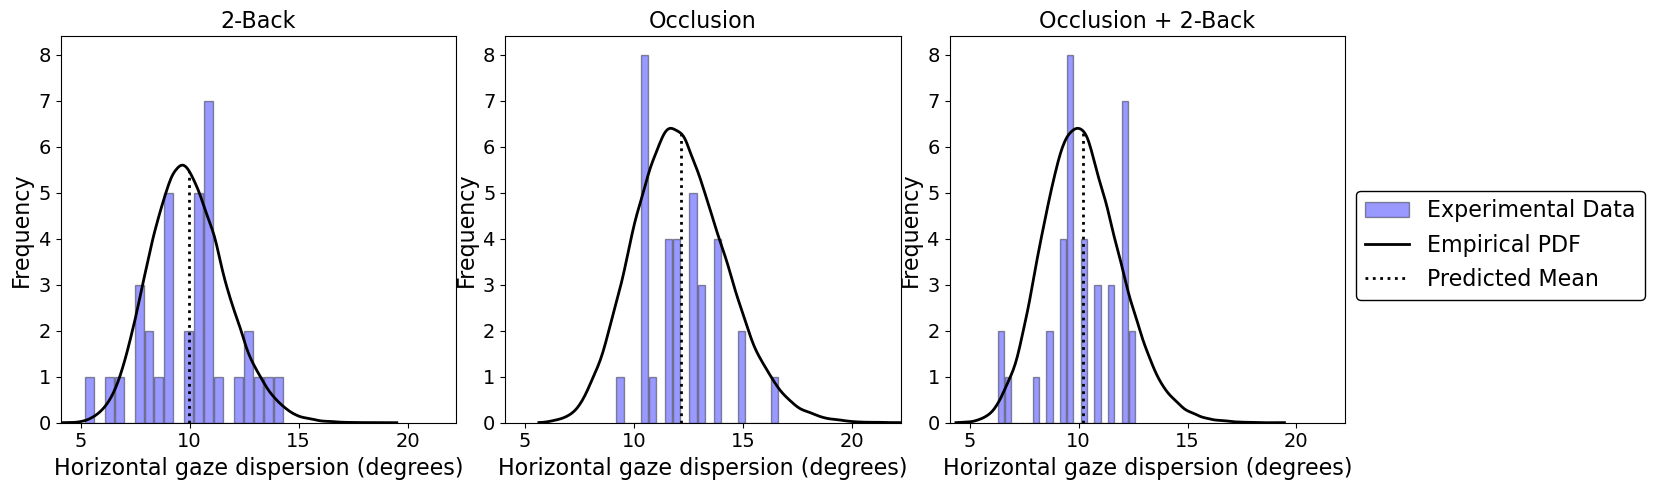

         Comparison     t_stat        p_value
0  (0, 1) vs (1, 0) -41.593569  5.900581e-273
1  (0, 1) vs (1, 1)  -4.358317   1.377146e-05
2  (1, 0) vs (1, 1)  37.752168  6.437795e-236


In [10]:
DV = 'Yaw_Degree'

# Run model and get cleaned EMMs
model, emms = run_gamma_with_emm_filtered_no_fatigue(df, DV, n_sims=2000)

# Print model summary
print(model.summary())

# Print EMM table (only three combinations, no Fatigue)
print(emms)

# Plot predicted distributions
plot_predictions_three_conditions_single_legend(df, DV, model, "Occlusion", "TwoBack", 'Horizontal gaze dispersion (degrees)', combos=None, n_sims=2000)

# Run post-hoc paired t-tests
posthoc_results = posthoc_emms_ttests(model, df, DV, n_sims=2000)
print(posthoc_results)

## run results for vertical dispersion

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Pitch_Degree   No. Observations:                  105
Model:                            GLM   Df Residuals:                      100
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                        0.026516
Method:                          IRLS   Log-Likelihood:                -212.43
Date:                Wed, 11 Feb 2026   Deviance:                       2.8646
Time:                        17:14:02   Pearson chi2:                     2.65
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4618
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.1983      0.04

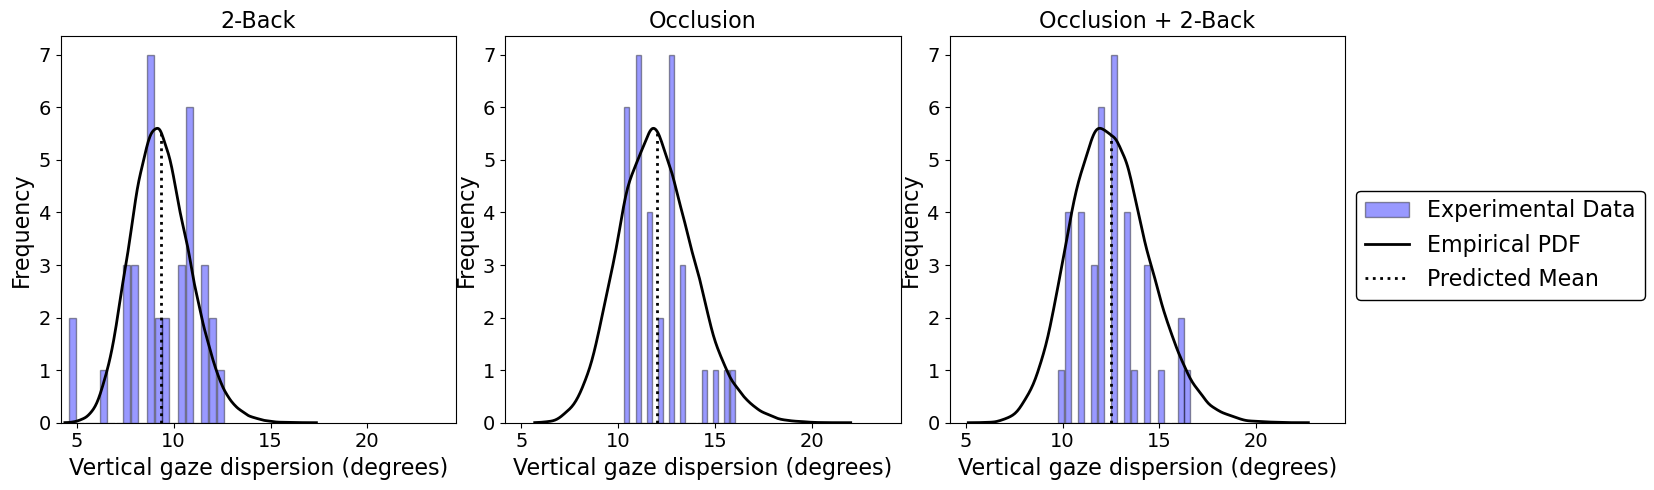

         Comparison     t_stat       p_value
0  (0, 1) vs (1, 0) -48.755559  0.000000e+00
1  (0, 1) vs (1, 1) -54.284147  0.000000e+00
2  (1, 0) vs (1, 1)  -5.940369  3.345837e-09


In [11]:
DV = 'Pitch_Degree'

# Run model and get cleaned EMMs
model, emms = run_gamma_with_emm_filtered_no_fatigue(df, DV, n_sims=2000)

# Print model summary
print(model.summary())

# Print EMM table (only three combinations, no Fatigue)
print(emms)

# Plot predicted distributions
plot_predictions_three_conditions_single_legend(df, DV, model, "Occlusion", "TwoBack", 'Vertical gaze dispersion (degrees)', combos=None, n_sims=2000)

# Run post-hoc paired t-tests
posthoc_results = posthoc_emms_ttests(model, df, DV, n_sims=2000)
print(posthoc_results)

## run results for reaction time

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     RT   No. Observations:                  105
Model:                            GLM   Df Residuals:                      100
Model Family:                   Gamma   Df Model:                            4
Link Function:                    log   Scale:                        0.062382
Method:                          IRLS   Log-Likelihood:                -42.288
Date:                Wed, 11 Feb 2026   Deviance:                       5.9451
Time:                        17:14:04   Pearson chi2:                     6.24
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1111
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2036      0.07

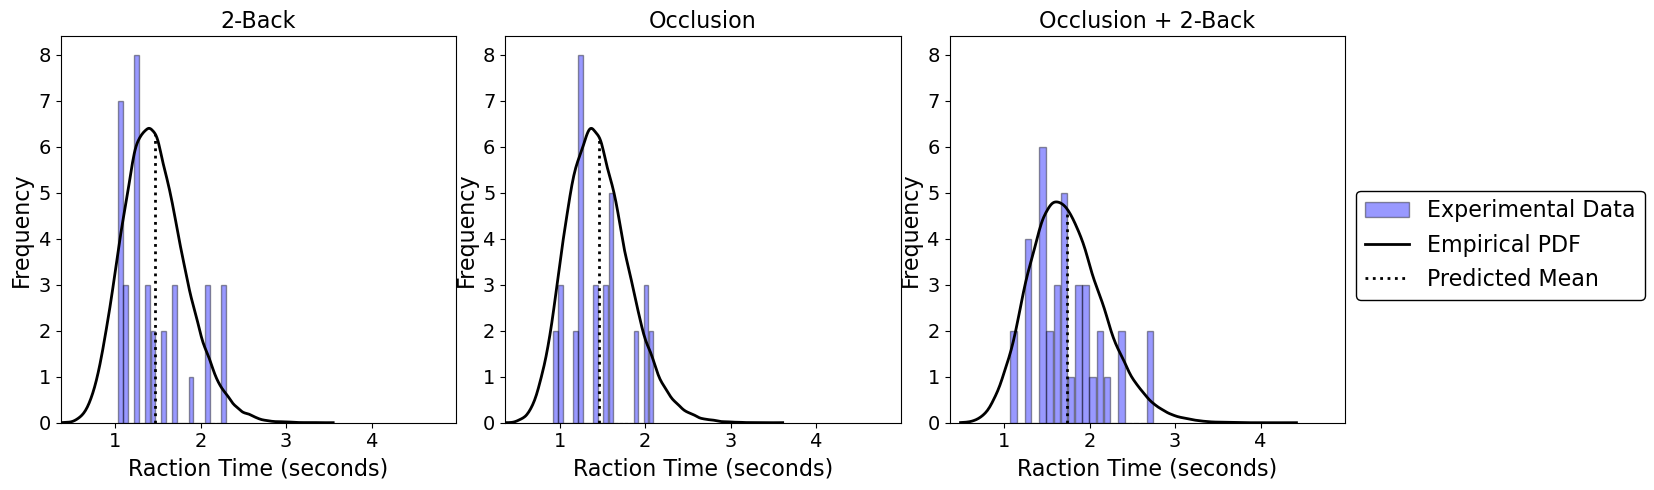

         Comparison     t_stat        p_value
0  (0, 1) vs (1, 0)  -4.647714   3.575382e-06
1  (0, 1) vs (1, 1) -23.164779  2.346244e-105
2  (1, 0) vs (1, 1) -18.926935   1.277128e-73


In [12]:
DV = 'RT'

# Run model and get cleaned EMMs
model, emms = run_gamma_with_emm_filtered_no_fatigue(df, DV, n_sims=2000)

# Print model summary
print(model.summary())

# Print EMM table (only three combinations, no Fatigue)
print(emms)

# Plot predicted distributions
plot_predictions_three_conditions_single_legend(df, DV, model, "Occlusion", "TwoBack", 'Raction Time (seconds)', combos=None, n_sims=2000)

# Run post-hoc paired t-tests
posthoc_results = posthoc_emms_ttests(model, df, DV, n_sims=2000)
print(posthoc_results)



### run predicted reaction probabilities


 probability of racting after TOR 


===== Probability Predicted Value > TOR =====

             Condition  Probability_above_TOR     N
Occlusion=0, TwoBack=1               0.678243 70000
Occlusion=1, TwoBack=0               0.672530 66000
Occlusion=1, TwoBack=1               0.866770 74000

===== Pairwise Chi-Squared Tests =====

                                      Comparison        Chi2  p_value  Higher_Prob_Condition
Occlusion=0, TwoBack=1 vs Occlusion=1, TwoBack=0    5.031093 0.024896 Occlusion=0, TwoBack=1
Occlusion=0, TwoBack=1 vs Occlusion=1, TwoBack=1 7333.973269 0.000000 Occlusion=1, TwoBack=1
Occlusion=1, TwoBack=0 vs Occlusion=1, TwoBack=1 7551.802917 0.000000 Occlusion=1, TwoBack=1

 probability of crash 


===== Probability Predicted Value > TOR =====

             Condition  Probability_above_TOR    N
Occlusion=0, TwoBack=1               0.000840 1190
Occlusion=1, TwoBack=0               0.000000 1122
Occlusion=1, TwoBack=1               0.008744 1258

===== Pairwise C

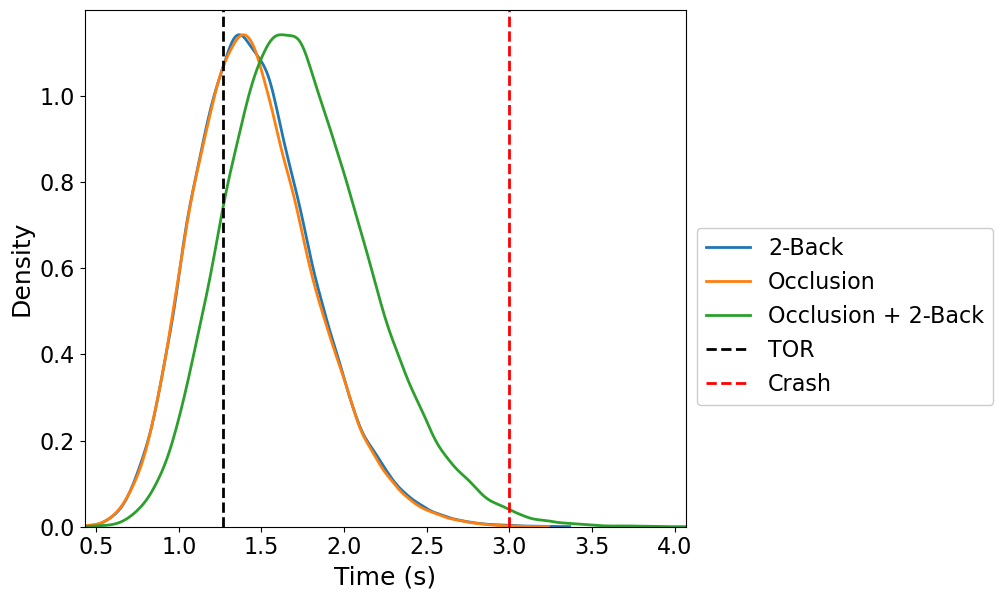

In [29]:
#Chi-squared test of reacting after TOR and crash
TOR = 1.27#time it took from the brake lights onset to the TOR
Crash = 3.0

#probability of reacting after TOR
print ('\n probability of racting after TOR \n')
probability_above_threshold_with_chi2(
        df, DV, model, "Occlusion", "TwoBack", TOR,
        combos=None, n_sims=2000, verbose=True)

#probability of crash
print ('\n probability of crash \n')
probability_above_threshold_with_chi2(
        df, DV, model, "Occlusion", "TwoBack", Crash,
        combos=None, n_sims=34, verbose=True)

#plot the 3 KDEs together
plot_three_condition_kdes(df, DV, model, "Occlusion", "TwoBack",
                              combos=None, n_sims=2000,
                              match_y_scale=True)

### run actual reaction probabilities

In [14]:
#probability of reacting before TOR
print ('probability of reacting before TOR')
results = run_all_chi_tests_fixed_manual(df, target_var="Reacted_Before_TOR")
print(results)


probability of reacting before TOR
                               Comparison  A_pos  A_neg    A_prob  B_pos  \
0  Occlusion1_2Back0 vs Occlusion0_2Back1     10     23  0.303030     11   
1  Occlusion1_2Back0 vs Occlusion1_2Back1     10     23  0.303030      4   
2  Occlusion0_2Back1 vs Occlusion1_2Back1     11     24  0.314286      4   

   B_neg    B_prob      Chi2   p_value                 Table  
0     24  0.314286  0.010081  0.920024  [[10, 23], [11, 24]]  
1     33  0.108108  4.142097  0.041829   [[10, 23], [4, 33]]  
2     33  0.108108  4.635741  0.031313   [[11, 24], [4, 33]]  


In [63]:
#probability of crash
print ('probability of crash')
results = run_all_chi_tests_fixed_manual(df, target_var="Crash")
print(results)

probability of crash
                               Comparison  A_pos  A_neg    A_prob  B_pos  \
0  Occlusion1_2Back0 vs Occlusion0_2Back1      8     25  0.242424      9   
1  Occlusion1_2Back0 vs Occlusion1_2Back1      8     25  0.242424     10   
2  Occlusion0_2Back1 vs Occlusion1_2Back1      9     26  0.257143     10   

   B_neg    B_prob      Chi2   p_value                Table  
0     26  0.257143  0.019625  0.888590   [[8, 25], [9, 26]]  
1     27  0.270270  0.070805  0.790168  [[8, 25], [10, 27]]  
2     27  0.270270  0.015956  0.899480  [[9, 26], [10, 27]]  


### run gaze dispersion descriptives for the periods of occlusion


=== DESCRIPTIVES ===
                    Horizontal gaze dispersion                                             \
                                          mean    std median    min     max   skew    sem   
Condition                                                                                   
Occlusion                                6.721  3.147  6.596  0.941  14.358  0.251  0.548   
Occlusion + TwoBack                      6.252  3.296  6.202  0.236  11.685  0.001  0.542   

                    Vertical gaze dispersion                                             
                                        mean    std median    min     max   skew    sem  
Condition                                                                                
Occlusion                              6.557  1.983  6.637  1.146   9.090 -1.007  0.345  
Occlusion + TwoBack                    6.986  2.148  7.469  2.094  10.482 -0.500  0.353  

=== QUARTILES ===

--- Occlusion ---
      Horizontal gaze di

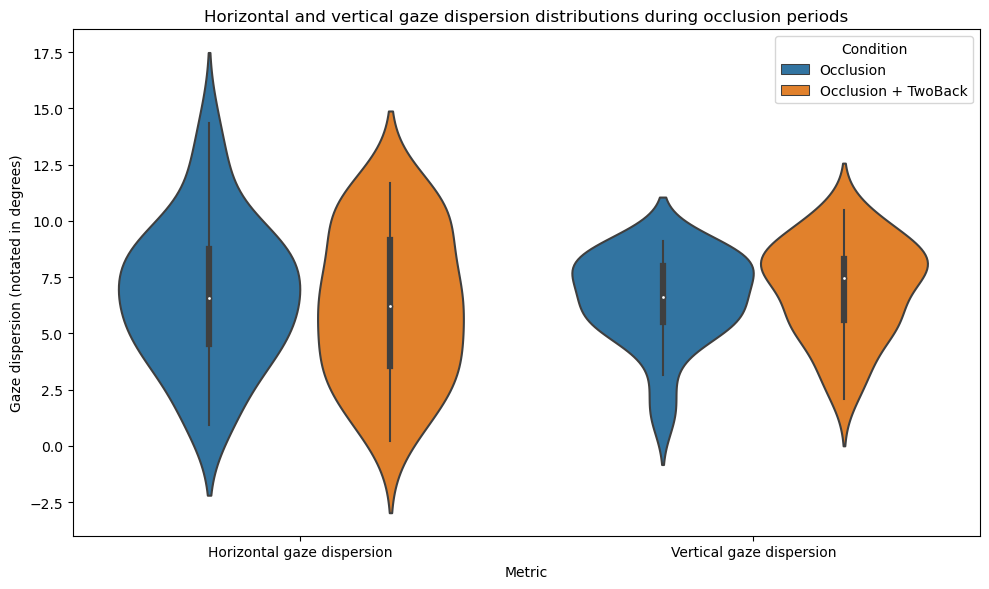

In [95]:
desc = occlusion_descriptives_and_plots(df)